# Face Verification Methods


The kernel gives some overview of some basic methods for face verification. It uses FaceNet model developed by Hiroki Taniai and availble in [this repository](https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn)

In [1]:
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import Sequential


## Data Preprocessing

The model requires images 160x160x3, passing images of shape 224x224x3 gives better result.<br>
The data processed for binary classification: every sample contains two images with corresponding binary target


In [4]:
y=[]
X=[]


for dirname, _, filenames in os.walk('/kaggle/input/yale-face-database/data'):
    
    
    for filename in filenames:
        if filename!="Readme.txt":
            b=plt.imread(os.path.join(dirname, filename))
       
            try:
                b= cv2.cvtColor(b,cv2.COLOR_GRAY2RGB) 
            except:
                pass



            b=cv2.resize(b, (224,224),interpolation = cv2.INTER_AREA)

            if b.shape==(224,224,3) :

                y.append(int(filename[7:9]))
                X.append(b)




            else:
                print(face.shape)

In [5]:
#sort according to the person
data=[]
for i in range(1,16):
    person=[]
    for u in range(len(y)):
        if y[u]==i:
            
            person.append(X[u])
    data.append([person, i*len(person)])
    print(str(len(person))+" images  for class "+ str(i))

11 images  for class 1
11 images  for class 2
11 images  for class 3
11 images  for class 4
11 images  for class 5
11 images  for class 6
11 images  for class 7
11 images  for class 8
11 images  for class 9
11 images  for class 10
11 images  for class 11
11 images  for class 12
11 images  for class 13
11 images  for class 14
11 images  for class 15


In [6]:

import random 
random.seed(42)
newX1=[]
newX2=[]
newY=[]
for i in range(len(data)):
    parts= int(len(data[i][0])/2)
    
    #positive sampling
    for u in range(parts):
        
        newX1.append(data[i][0][u])
        newX2.append(data[i][0][u+parts])
        newY.append(0)
        
        
    
    #negative sampling
    for uu in range(parts):
        
        numbers = list(range(0,i)) + list(range(i+1,11))
        r = random.choice(numbers)
        g = random.randint(0,len(data[r][0])-1)
        newX1.append(data[i][0][uu])
        newX2.append(data[r][0][g])
        newY.append(1)

print("Target values count: "+ str(np.unique(newY, return_counts=True)))

Target values count: (array([0, 1]), array([75, 75]))


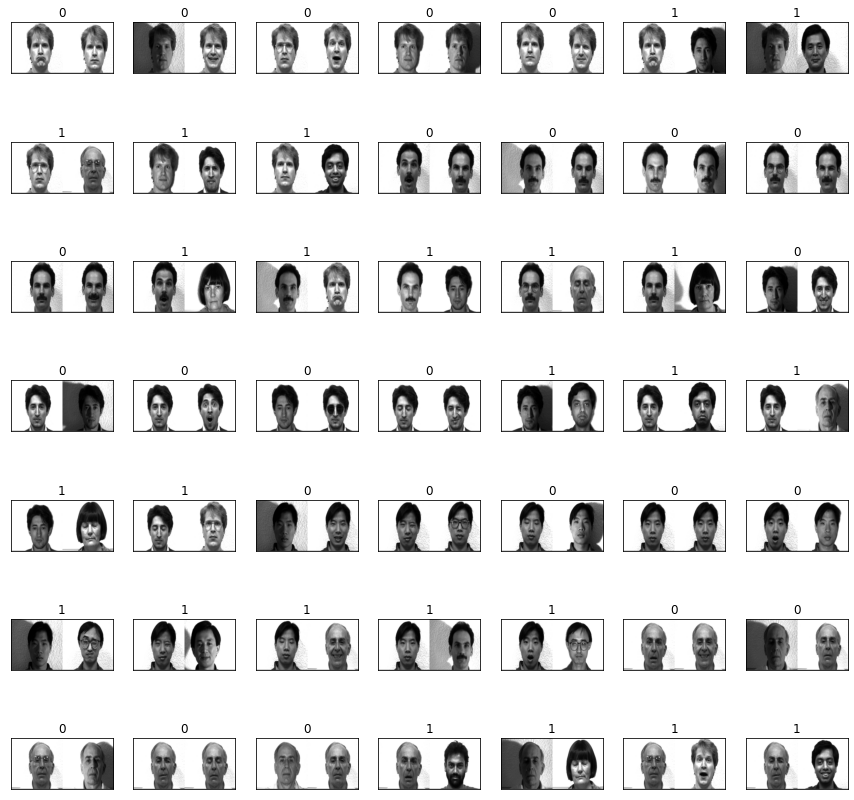

In [7]:
fig=plt.figure(figsize=(15, 15))
columns = 7
rows = 7
for i in range(1, columns*rows +1):
    ax=fig.add_subplot(rows, columns, i)
    
    plt.imshow(np.concatenate([newX1[i-1],newX2[i-1]], axis=1))
    ax.title.set_text(newY[i-1])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [8]:
c = list(zip(newX1, newX2, newY))

random.shuffle(c)

a, b, y = zip(*c)
    

### PCA dimention reduction and eigenfaces visualization

PCA is a basic method used for image feature extraction.Best results visualizing eigenfaces achieved when applied on 2D images.

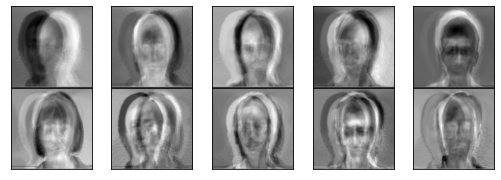

In [9]:
Xpca=np.array(a)
Xpca=Xpca.reshape(Xpca.shape[0],Xpca.shape[1]*Xpca.shape[2]*Xpca.shape[3])
from sklearn.decomposition import PCA

faces_pca = PCA(n_components=0.9)
faces_pca.fit(Xpca)
fig, axes = plt.subplots(2,5,figsize=(9,3),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.interp(faces_pca.components_[i], (min(faces_pca.components_[i]),max(faces_pca.components_[i])), (0, 255)).reshape(224,224,3).astype("int"))


### FaceNet Features Extraction

While PCA can be used for feature extraction, CNN is considered more powerful tool to extract image features

In [11]:
base_model = models.load_model('../input/facenet/facenet_keras.h5')

base_model.load_weights("../input/facenet/facenet_keras_weights.h5")
base_model.trainable=False


In [12]:
output1=base_model.predict(np.array(a)/255)
output2=base_model.predict(np.array(b)/255)

In [13]:
indexes1=[i for i,x in enumerate(y) if x == 1]
indexes0=[i for i,x in enumerate(y) if x == 0]

### Features Subtraction

- get absolute values of features subtracted between two sample images 
- sum all the absolute values for each array
- if there is a visual difference between positive and negative samples

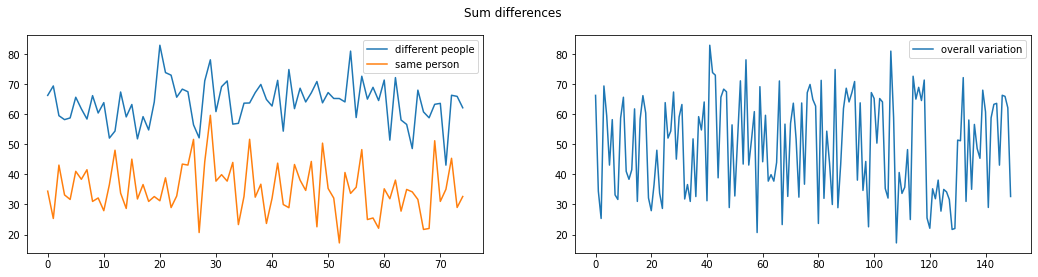

In [17]:
arr=[]
su=[]
for s in range(len(output1)):
    oo = np.abs(np.subtract(np.array(output1[s]),np.array(output2[s])))
    arr.append(oo)
    su.append(oo.sum())
    
a = np.array(su)
su1=list(a[indexes1])
su0=list(a[indexes0])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Sum differences")
axs[0].plot(list(range(75)),su1, list(range(75)),su0)
axs[0].legend(["different people", "same person"])
#axs[0].title("Euclidean distance")
axs[1].plot(list(range(150)),su)
axs[1].legend(["overall variation"])

    

In [18]:
from scipy import stats
import statistics
print(stats.describe(su))
print("median "+str(statistics.median(su)))

DescribeResult(nobs=150, minmax=(17.240364, 82.862564), mean=49.536583, variance=265.9869, skewness=-0.06938136368989944, kurtosis=-1.2803152589691404)
median 51.489688873291016


### SVM Classifier 
Visually there is a difference between similar images is lower than the difference between the images that contains the different people. We apply SVM to see accuracy of the model.

In [19]:


scorer = make_scorer(f1_score, average='macro')
X_train, X_test,y_train,y_test= train_test_split(arr,y,test_size=0.2, random_state=42)

tuned_parameters = [{'kernel': ['rbf','poly','linear'], 'gamma': [1e-3, 1e-4, 1e-5],
                     'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']
#for score in scores:

clf = GridSearchCV(SVC(), tuned_parameters, scoring=scorer)
clf.fit(Normalizer().fit(X_train).transform(X_train), y_train)
params=clf.best_params_
cv= SVC(C=params["C"], gamma= params["gamma"], kernel=params["kernel"])
cv.fit(Normalizer().fit(X_train).transform(X_train), y_train)

y_pred = cv.predict(Normalizer().fit(X_test).transform(X_test))
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

precision    recall  f1-score    support
0              0.833333  0.882353  0.857143  17.000000
1              0.833333  0.769231  0.800000  13.000000
accuracy       0.833333  0.833333  0.833333   0.833333
macro avg      0.833333  0.825792  0.828571  30.000000
weighted avg   0.833333  0.833333  0.832381  30.000000

### Replacing sum by cosine and euclidean distance 


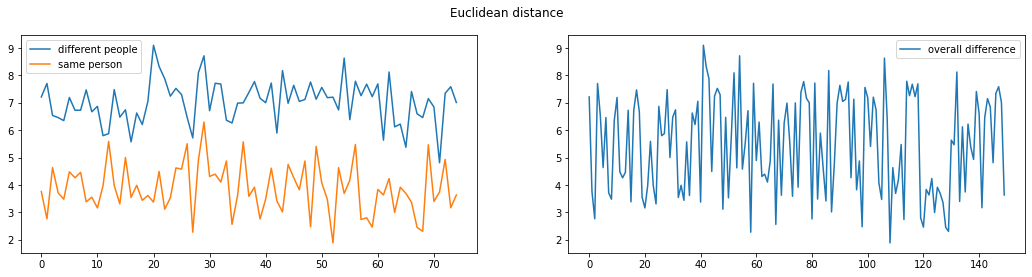

In [21]:
import scipy
euc=[]
for s in range(len(output1)):
    oo = scipy.spatial.distance.euclidean(np.array(output1[s]),np.array(output2[s]))
    euc.append(oo)
a = np.array(euc)
euc1=list(a[indexes1])
euc0=list(a[indexes0])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Euclidean distance")
axs[0].plot(list(range(75)),euc1, list(range(75)),euc0)
axs[0].legend(["different people", "same person"])
#axs[0].title("Euclidean distance")
axs[1].plot(list(range(150)),euc)
axs[1].legend(["overall difference"])


In [23]:

print(stats.describe(euc))
print("median "+str(statistics.median(euc)))

DescribeResult(nobs=150, minmax=(1.8859057426452637, 9.097798347473145), mean=5.455773261388143, variance=3.226597248705269, skewness=-0.06703203520937963, kurtosis=-1.2819158009770941)
median 5.572854518890381


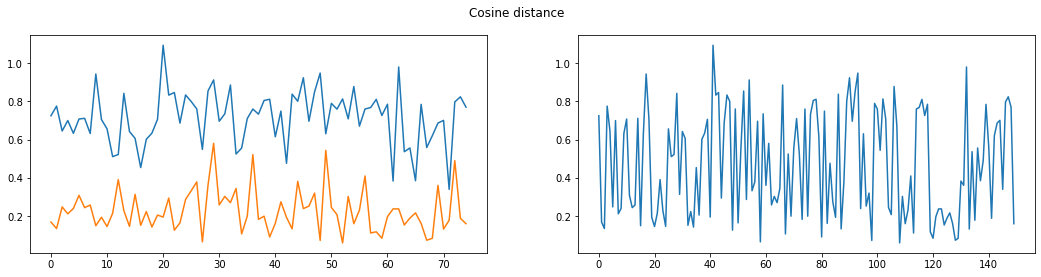

In [24]:
cos=[]
for s in range(len(output1)):
    oo = scipy.spatial.distance.cosine(np.array(output1[s]),np.array(output2[s]))
    cos.append(oo)
a = np.array(cos)
cos1=list(a[indexes1])
cos0=list(a[indexes0])
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Cosine distance")
axs[0].plot(list(range(75)), cos1, list(range(75)),cos0)
#axs[0].title("Euclidean distance")
axs[1].plot(list(range(150)),cos)


In [25]:
print(stats.describe(cos))
print("median "+str(statistics.median(cos)))

DescribeResult(nobs=150, minmax=(0.05966442823410034, 1.0927783846855164), mean=0.4716733796025316, variance=0.07571063704336514, skewness=0.15159011573666603, kurtosis=-1.3982272157325777)
median 0.464690238237381


### Siamese Network

The CNN model implements a logic similar to the one demonstrated inthe previous sections
- The features are extracted from images using FaceNet
- The features are subtracted to get a single tensor
- ANN used for the final classification

In [29]:
features=Model(base_model.input, base_model.output)
import tensorflow.keras.backend as K
import tensorflow
def distance(vecs):
    x, y = vecs
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    
    return K.abs(x-y)

v=Input((224,224,3))
p=Input((224,224,3))

featuresA=features(v)
featuresB=features(p)
distance= Lambda(distance)([featuresA,featuresB])

x= Dense(96, activation="relu")(distance)
x= Dropout(0.3)(x)
x= Dense(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[v,p],outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 128)          22808144    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128)          0           functional_13[0][0]  

In [30]:
c = list(zip(newX1, newX2, newY))
random.shuffle(c)
a, b, y = zip(*c)

model.fit([np.array(a)[:120]/255, np.array(b)[:120]/255],np.array(y)[:120],validation_data=([np.array(a)[120:]/255, np.array(b)[120:]/255],np.array(y)[120:]), epochs=10, batch_size=16)

Epoch 1/10
8/8 [==============================] - 18s 2s/step - loss: 0.6925 - accuracy: 0.4417 - val_loss: 0.6466 - val_accuracy: 0.5667
Epoch 2/10
8/8 [==============================] - 14s 2s/step - loss: 0.6615 - accuracy: 0.4833 - val_loss: 0.6280 - val_accuracy: 0.5667
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 0.6389 - accuracy: 0.4833 - val_loss: 0.6092 - val_accuracy: 0.5667
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 0.6212 - accuracy: 0.5167 - val_loss: 0.5876 - val_accuracy: 0.6000
Epoch 5/10
8/8 [==============================] - 15s 2s/step - loss: 0.5972 - accuracy: 0.5250 - val_loss: 0.5692 - val_accuracy: 0.7000
Epoch 6/10
8/8 [==============================] - 14s 2s/step - loss: 0.5556 - accuracy: 0.6750 - val_loss: 0.5403 - val_accuracy: 0.7667
Epoch 7/10
8/8 [==============================] - 15s 2s/step - loss: 0.5211 - accuracy: 0.7667 - val_loss: 0.5101 - val_accuracy: 0.8000
Epoch 8/10
8/8 [==================